In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def read_data(file_name):
    return pd.read_csv(file_name)

data = read_data("Terry_Stops.csv")

In [3]:
# Columns
# ['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
#      'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
#      'Officer Gender', 'Officer Race', 'Subject Perceived Race',
#      'Subject Perceived Gender', 'Reported Date', 'Reported Time',
#      'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
#      'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat']

df = data[['Subject Age Group', 'Stop Resolution', 'Officer Gender', 'Officer Race',
            'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
            'Initial Call Type', 'Final Call Type',
            'Call Type', 'Arrest Flag', 'Frisk Flag']]

In [4]:
# total terry stops
rid_unknown = (df['Subject Perceived Race'] != 'Unknown')
rid_dash = (df['Subject Perceived Race'] != '-')
full_df = df[rid_unknown & rid_dash]

print("'NA' excluding Terry Stops: "+ str(len(full_df)))

'NA' excluding Terry Stops: 38960


In [5]:
# looking at ONVIEW stops only
onview_only = full_df['Call Type'] == 'ONVIEW'
onview_df = full_df[onview_only]

# Initial call type is SUSPICIOUS stops/people
sus_stop = onview_df['Initial Call Type'] == 'SUSPICIOUS STOP - OFFICER INITIATED ONVIEW'
sus_person = onview_df['Initial Call Type'] == 'SUSPICIOUS PERSON, VEHICLE OR INCIDENT'
traffic_stop = onview_df['Initial Call Type'] == 'TRAFFIC STOP - OFFICER INITIATED ONVIEW'

onview_df = onview_df[sus_person | traffic_stop | sus_stop]

# NUM VALUE total stops
total_stops = len(onview_df)
print('Total Stops in DATAFRAME: ' + str(total_stops))

Total Stops in DATAFRAME: 3589


In [6]:
# filtered for specified RACE
def subject_race(df, race):
    race_df = df[df['Subject Perceived Race'] == race]
    return race_df

In [7]:
# Black Ratios
total_black_df = subject_race(onview_df, 'Black or African American')
total_black_num = len(total_black_df)
total_black_prop = round(total_black_num / total_stops, 4)
print('Total Black People Stopped: ' + str(total_black_num))
print('Total Black Stopped Proportion:' + str(total_black_prop))
print()

# White Ratios
total_white_df = subject_race(onview_df, 'White')
total_white_num = len(total_white_df)
total_white_prop = round(total_white_num / total_stops, 4)
print('Total White People Stopped: ' + str(total_white_num))
print('Total White Stopped Proportion:' + str(total_white_prop))

Total Black People Stopped: 1061
Total Black Stopped Proportion:0.2956

Total White People Stopped: 2095
Total White Stopped Proportion:0.5837


In [13]:
seattle_total = 744,949 # population of city of seattle
seattle_white = 469470
seattle_black = 49678
seattle_white_prop = 0.63
seattle_black_prop = 0.067

print('Black subjects population disparity: ' + str(round(total_black_prop - seattle_black_prop, 4)))
print('White subjects population disparity: ' + str(round(total_white_prop - seattle_white_prop, 4)))
print()
print('Proportion disparity -- looking at the city of Seattle\'s propulation, if we have a group of 100 people, ' + 
      'we would expect only ' + str(round(seattle_black_prop * 100)) + ' subjects to be black but we see that the reality is that ' +
      str(round(total_black_prop*100)) + ' people are black. ' + 
      'This means that if you are Black, you are nearly 4x more likely to be stopped than what the population entails.')
print()
print('On the other hand, looking at the city of Seattle\'s propulation, if we have a group of 100 people, ' + 
      'we would expect ' + str(round(seattle_white_prop * 100)) + ' subjects to be white but we see that the reality is that ' +
      str(round(total_white_prop*100)) + ' people are white. ' + 
      'This means that if you are White, you are less likely to be stopped than what the population entails.')

Black subjects population disparity: 0.2286
White subjects population disparity: -0.0463

Proportion disparity -- looking at the city of Seattle's propulation, if we have a group of 100 people, we would expect only 7 subjects to be black but we see that the reality is that 30 people are black. This means that if you are Black, you are nearly 4x more likely to be stopped than what the population entails.

On the other hand, looking at the city of Seattle's propulation, if we have a group of 100 people, we would expect 63 subjects to be white but we see that the reality is that 58 people are white. This means that if you are White, you are less likely to be stopped than what the population entails.


In [9]:
# Add YEARS column for line graph
def add_year(df): # function to add YEAR column
    #value = df['Reported Date']
    dates = []
    for index in df['Reported Date']:
        year_full = datetime.datetime.strptime(index, '%Y-%m-%dT%H:%M:%S').date()
        year = year_full.strftime('%Y')
        dates.append(year)
    df['Year'] = dates
    years = df.groupby('Year')['Year'].count()
    years_series = {'Year': years.index, 'Count': years.values}
    years_df = pd.DataFrame(years_series)
    return years_df

In [10]:
total_years_df = add_year(onview_df)
black_years_df = add_year(total_black_df)
white_years_df = add_year(total_white_df)

# disparity calculations
black_disparity = (black_years_df['Count'] / total_years_df['Count']) - seattle_black_prop
white_disparity = (white_years_df['Count'] / total_years_df['Count']) - seattle_white_prop

# stopped proportion calculations
black_stopped_prop = black_years_df['Count'] / total_years_df['Count']
white_stopped_prop = white_years_df['Count'] / total_years_df['Count']

# dataframe of YEAR and Proportion DISPARITY of white v. black
disparity = {'Year': total_years_df['Year'], 'Black Disparity': black_disparity, 
               'White Disparity': white_disparity}
disparity_df = pd.DataFrame(data=disparity)

# dataframe of YEAR and stopped proportions v. population proportion 
proportions = {'Year': total_years_df['Year'], 'Black STOPPED Prop': black_stopped_prop,
               'Black Population Prop': seattle_black_prop, 
               'White STOPPED Prop': white_stopped_prop, 'White Population Prop': seattle_white_prop}
prop_df = pd.DataFrame(data=proportions)

# dataframe same to prop.df but PERCENTAGES
percentages = {'Year': prop_df['Year'], 'Black STOPPED Percent': round(prop_df['Black STOPPED Prop'] * 100, 2),
              'White STOPPED Percent': round(prop_df['White STOPPED Prop'] * 100, 2),
              'Black Population Percent': round(prop_df['Black Population Prop'] * 100, 2),
              'White Population Percent': round(prop_df['White Population Prop'] * 100, 2)}
perc_df = pd.DataFrame(data=percentages)

# exporting dataframes to CSV file (for datawrapper use mostly)
disparity_df.to_csv('Disparity.csv', index = False)
prop_df.to_csv('Stopped_Props.csv', index = False)
perc_df.to_csv('Stopped_Percent.csv', index = False)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5, 1.0, 'ONVIEW Terry Stops from 2015-2020')

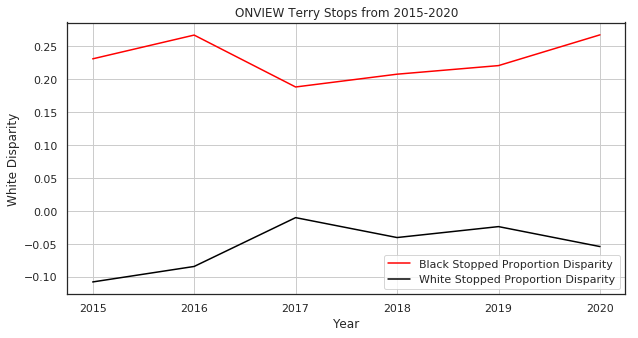

In [11]:
# Visualization (DRAFT) to show the difference in proportion disparities -- FINAL on file made through datawrapper
sns.set_style('white')
fig, ax = plt.subplots(1, figsize = (10, 5))
sns.lineplot(ax=ax, x='Year', y='Black Disparity', data=disparity_df,
            color='red', label='Black Stopped Proportion Disparity')
sns.lineplot(ax=ax, x='Year', y='White Disparity', data=disparity_df,
            color='black', label='White Stopped Proportion Disparity')
ax.grid(True)
ax.set_title('ONVIEW Terry Stops from 2015-2020')
# plt.savefig('ONVIEW_stops.png')

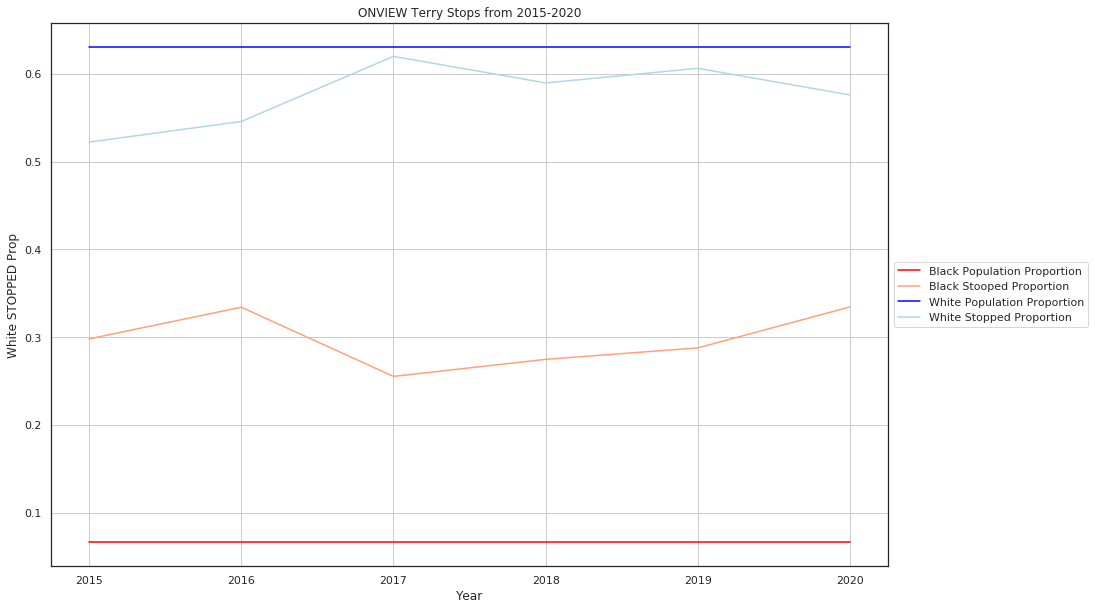

In [12]:
# Visualization (DRAFT) to show the estimated proportions vs. what the true proportion is -- FINAL is in project folder using datawrapper
sns.set_style('white')
fig, ax = plt.subplots(1, figsize = (15, 10))
sns.lineplot(ax=ax, x='Year', y='Black Population Prop', data=prop_df,
            color='red', label='Black Population Proportion')
sns.lineplot(ax=ax, x='Year', y='Black STOPPED Prop', data=prop_df,
            color='lightsalmon', label='Black Stooped Proportion')
sns.lineplot(ax=ax, x='Year', y='White Population Prop', data=prop_df,
            color='blue', label='White Population Proportion')
sns.lineplot(ax=ax, x='Year', y='White STOPPED Prop', data=prop_df,
            color='lightblue', label='White Stopped Proportion')
ax.grid(True)
ax.set_title('ONVIEW Terry Stops from 2015-2020')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('ONVIEW_stops.png')
